In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

In [2]:
symbols = ['AAPL', 'MSFT', 'GOOGL', 'JPM', 'TSLA', 'IBM']
num_of_symbols = len(symbols)
stock_data = 'stock_data.csv'

In [3]:
START_DATE = '2020-01-01'
END_DATE = '2024-12-31'

In [4]:
raw_data = yf.download(symbols, start=START_DATE, end=END_DATE, auto_adjust = False)
stock_prices = raw_data['Adj Close']
display(stock_prices)

[*********************100%***********************]  6 of 6 completed


Ticker,AAPL,GOOGL,IBM,JPM,MSFT,TSLA
Date,,,,,,
2020-01-02,72.620842,68.026024,101.245125,120.733551,153.042297,28.684000
2020-01-03,71.914818,67.670151,100.437675,119.140312,151.136673,29.534000
2020-01-06,72.487862,69.473839,100.258247,119.045586,151.527267,30.102667
2020-01-07,72.146942,69.339645,100.325531,117.021721,150.145691,31.270666
2020-01-08,73.307526,69.833183,101.162910,117.934624,152.537308,32.809334
...,...,...,...,...,...,...
2024-12-23,254.655716,194.171051,219.003876,235.713242,433.583038,430.600006
2024-12-24,257.578674,195.647552,221.451187,239.589218,437.647400,462.279999
2024-12-26,258.396667,195.138763,221.924850,240.409912,436.432068,454.130005


In [5]:
stock_prices.to_csv(stock_data)
portfolio_data = pd.read_csv(stock_data, index_col = 'Date')
display(portfolio_data.head())

,AAPL,GOOGL,IBM,JPM,MSFT,TSLA
Date,,,,,,
2020-01-02,72.620842,68.026024,101.245125,120.733551,153.042297,28.684000
2020-01-03,71.914818,67.670151,100.437675,119.140312,151.136673,29.534000
2020-01-06,72.487862,69.473839,100.258247,119.045586,151.527267,30.102667
2020-01-07,72.146942,69.339645,100.325531,117.021721,150.145691,31.270666
2020-01-08,73.307526,69.833183,101.162910,117.934624,152.537308,32.809334


In [6]:
display(portfolio_data.tail())

,AAPL,GOOGL,IBM,JPM,MSFT,TSLA
Date,,,,,,
2024-12-23,254.655716,194.171051,219.003876,235.713242,433.583038,430.600006
2024-12-24,257.578674,195.647552,221.451187,239.589218,437.647400,462.279999
2024-12-26,258.396667,195.138763,221.924850,240.409912,436.432068,454.130005
2024-12-27,254.974930,192.305450,219.842682,238.462036,428.881104,431.660004
2024-12-30,251.593079,190.789032,217.346039,236.632812,423.202911,417.410004


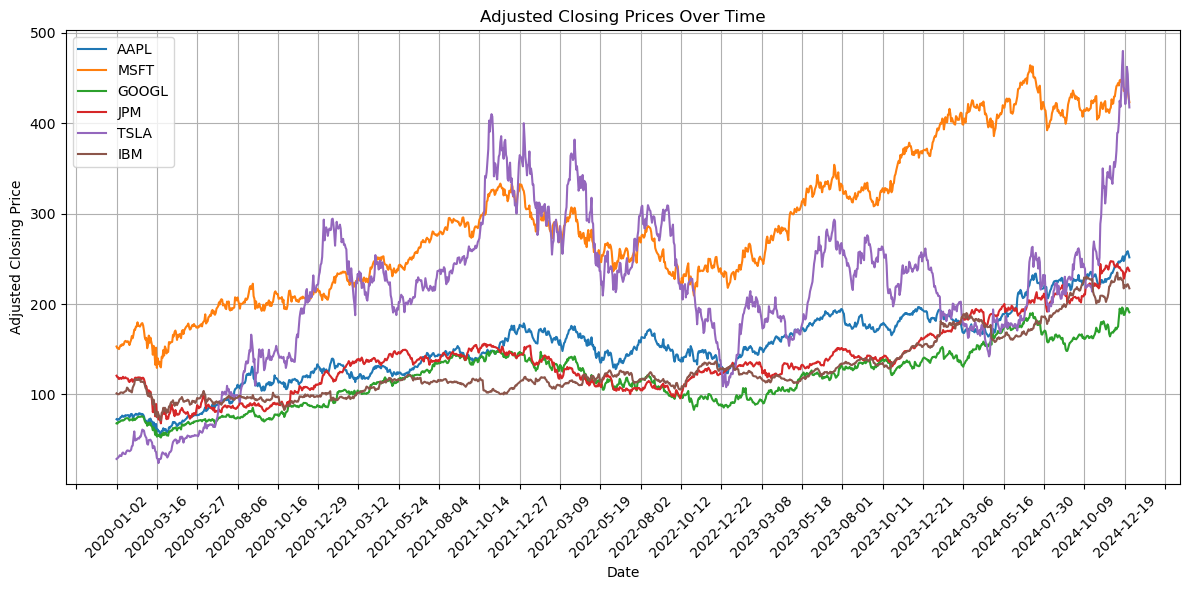

In [7]:
plt.figure(figsize=(12, 6))
for symbol in symbols:
    plt.plot(portfolio_data.index, portfolio_data[symbol], label=symbol)

plt.xlabel("Date")
plt.ylabel("Adjusted Closing Price")
plt.title("Adjusted Closing Prices Over Time")
plt.legend(loc="upper left")
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Reduce the number of displayed date labels
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(30))  # Adjust the number as needed

# Show the plot
plt.tight_layout()
plt.show()

In [8]:
daily_returns = portfolio_data.pct_change().dropna()
daily_returns.head()

,AAPL,GOOGL,IBM,JPM,MSFT,TSLA
Date,,,,,,
2020-01-03,-0.009722,-0.005231,-0.007975,-0.013196,-0.012452,0.029633
2020-01-06,0.007968,0.026654,-0.001786,-0.000795,0.002584,0.019255
2020-01-07,-0.004703,-0.001932,0.000671,-0.017001,-0.009118,0.038801
2020-01-08,0.016086,0.007118,0.008347,0.007801,0.015929,0.049205
2020-01-09,0.021241,0.010498,0.010568,0.003651,0.012493,-0.021945


In [9]:
display(daily_returns.tail())

,AAPL,GOOGL,IBM,JPM,MSFT,TSLA
Date,,,,,,
2024-12-23,0.003065,0.016823,-0.006402,0.003325,-0.003092,0.022657
2024-12-24,0.011478,0.007604,0.011175,0.016444,0.009374,0.073572
2024-12-26,0.003176,-0.002601,0.002139,0.003425,-0.002777,-0.017630
2024-12-27,-0.013242,-0.014519,-0.009382,-0.008102,-0.017302,-0.049479
2024-12-30,-0.013263,-0.007885,-0.011356,-0.007671,-0.013240,-0.033012


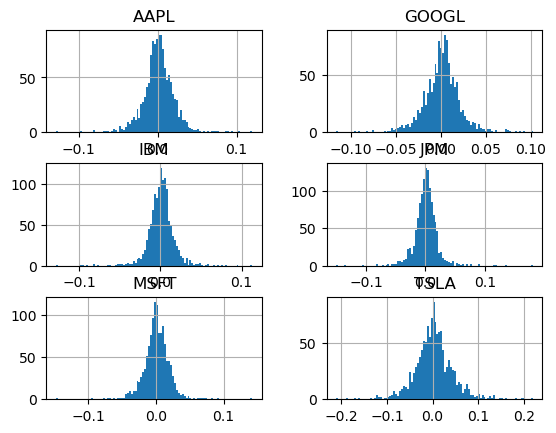

None

In [10]:
#we check the distribution of daily returns 
daily_returns.hist(bins=100)
display(plt.show())

In [11]:
#we find log returns to capture the idea of returns over time
log_returns  = np.log(1 +  portfolio_data.pct_change())
display(log_returns.head())

,AAPL,GOOGL,IBM,JPM,MSFT,TSLA
Date,,,,,,
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,-0.009770,-0.005245,-0.008007,-0.013284,-0.012530,0.029203
2020-01-06,0.007937,0.026305,-0.001788,-0.000795,0.002581,0.019072
2020-01-07,-0.004714,-0.001933,0.000671,-0.017147,-0.009159,0.038067
2020-01-08,0.015958,0.007092,0.008312,0.007771,0.015803,0.048033


In [12]:
log_returns.mean() * 252

AAPL     0.249304
GOOGL    0.206912
IBM      0.153276
JPM      0.135013
MSFT     0.204075
TSLA     0.537251
dtype: float64

In [13]:
#the covariance matrix
log_returns.cov()*252

,AAPL,GOOGL,IBM,JPM,MSFT,TSLA
AAPL,0.100265,0.067248,0.033830,0.042592,0.072596,0.104470
GOOGL,0.067248,0.105840,0.031208,0.042929,0.074289,0.088513
IBM,0.033830,0.031208,0.071939,0.049763,0.033981,0.029200
JPM,0.042592,0.042929,0.049763,0.105375,0.042063,0.061411
MSFT,0.072596,0.074289,0.033981,0.042063,0.093226,0.093285
TSLA,0.104470,0.088513,0.029200,0.061411,0.093285,0.448998


In [14]:
#assigning random weights to each symbol in the portfolio to begin monte carlo simulation
random_weights = np.array(np.random.random(num_of_symbols))

#weights should be standaradsed
rebalanced_weights = random_weights / np.sum(random_weights)

display(rebalanced_weights)

array([0.08353124, 0.18566757, 0.2222775 , 0.07285908, 0.29274955,
       0.14291505])

In [15]:
#calculate the expected returns, annualized according to number of trading days 252
expected_returns = np.sum(log_returns.mean() * rebalanced_weights) * 252
expected_returns

np.float64(0.23967257663244204)

In [16]:
expected_volatility = np.sqrt(
    np.dot(
        rebalanced_weights.T,
        np.dot(
            log_returns.cov()*252, 
            rebalanced_weights
        )
    )
)
expected_volatility

np.float64(0.26609475783464825)

In [17]:
#Sharpe Ratio
#assume some risk free rate of returns say returns on government treasury bonds
risk_free_returns = 0.015 

sharpe_ratio = (expected_returns - risk_free_returns)/expected_volatility

In [18]:
#create a data frame with our portfolio metrics for one itereation or one simulation
#we run multiple such iterations - the monte carlo simulation
metrics_df = pd.DataFrame(data = {
    'Expected Portfolio Returns': expected_returns,
    'Expected Portfolio Volatility': expected_volatility,
    'Portfolio Sharpe Ratio': sharpe_ratio
    }, index = [0])

metrics_df.head()

,Expected Portfolio Returns,Expected Portfolio Volatility,Portfolio Sharpe Ratio
0,0.239673,0.266095,0.844333


In [19]:
#we look for the minimum expected volatility and highest sharpe ratio (basically most return 
#for that amount of risk. number of simulations is the number of portfolios we get
num_of_portfolios = 3500

#predefine/ initialize arrays for storage of the values for each portfolio
weights_arr = np.zeros((num_of_portfolios, num_of_symbols))

returns_arr = np.zeros(num_of_portfolios)

volatility_arr = np.zeros(num_of_portfolios)

sharpe_arr = np.zeros(num_of_portfolios)

for i in range(num_of_portfolios):
    #calculate the weights:
    weights = np.array(np.random.random(num_of_symbols))
    #standardize the weights
    weights = weights / np.sum(weights)

    weights_arr[i, :] = weights

    returns_arr[i] = np.sum((log_returns.mean() * weights))*252

    volatility_arr[i] = np.sqrt(
        np.dot(
            weights.T,
            np.dot(
                log_returns.cov()*252, 
                weights
            )
        )
    )

    sharpe_arr[i] = (returns_arr[i] - risk_free_returns)/ volatility_arr[i]

In [20]:
simulated_data = [returns_arr, volatility_arr, sharpe_arr, weights_arr]

simulated_df = pd.DataFrame(data = simulated_data).T

simulated_df.columns = ['Returns', 'Volatility', 'Sharpe Ratio', 'Portfolio Weights']

display(simulated_df)

,Returns,Volatility,Sharpe Ratio,Portfolio Weights
0,0.263317,0.298743,0.831206,"[0.10857139150272993, 0.2527378765900524, 0.00..."
1,0.234049,0.274894,0.79685,"[0.03952595324292385, 0.2948589018246818, 0.07..."
2,0.283125,0.308143,0.870134,"[0.229094590104043, 0.14686761188293196, 0.067..."
3,0.213529,0.258121,0.769132,"[0.30915986585754196, 0.20289705348130935, 0.0..."
4,0.289559,0.318619,0.861714,"[0.26608540853072304, 0.35826310202395745, 0.0..."
...,...,...,...,...
3495,0.25399,0.28394,0.841692,"[0.13663877810811853, 0.020190163691688613, 0...."
3496,0.345663,0.371816,0.889319,"[0.33415950118985865, 0.11597908903523765, 0.0..."
3497,0.245675,0.265961,0.867325,"[0.21468565854208796, 0.05479810449903191, 0.2..."
3498,0.228946,0.26076,0.82047,"[0.13704457959871236, 0.028661814882488496, 0...."


In [21]:
#portfolio with the highest sharpe ratio

max_sharpe_port = simulated_df.loc[simulated_df['Sharpe Ratio'].idxmax()]

min_vol_port = simulated_df.loc[simulated_df['Volatility'].idxmin()]

print("Max Sharpe Ratio Portfolio")
print(max_sharpe_port)
display(max_sharpe_port['Portfolio Weights'])
print('-'*100)
print("Min Volatility Portfolio")
print(min_vol_port)
display(min_vol_port['Portfolio Weights'])

Max Sharpe Ratio Portfolio
Returns                                                       0.297751
Volatility                                                    0.309637
Sharpe Ratio                                                   0.91317
Portfolio Weights    [0.29777340475614433, 0.052815327375930234, 0....
Name: 3199, dtype: object


array([0.2977734 , 0.05281533, 0.30137073, 0.03904533, 0.01466406,
       0.29433115])

----------------------------------------------------------------------------------------------------
Min Volatility Portfolio
Returns                                                       0.182547
Volatility                                                    0.233646
Sharpe Ratio                                                  0.717097
Portfolio Weights    [0.05720137912374246, 0.1533272486685687, 0.42...
Name: 1155, dtype: object


array([0.05720138, 0.15332725, 0.42518047, 0.17890605, 0.1571599 ,
       0.02822495])